In [2]:
# Python imports
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

# Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
cfg.initialize(logging_level='WORKFLOW')

2019-10-02 10:37:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [3]:
# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.07780', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.04264', 'RGI60-02.03688', 'RGI60-02.00147', 'RGI60-02.03411']
rgidf = utils.get_rgi_glacier_entities(rgi_list)

In [4]:
cfg.PARAMS['border'] = 10
cfg.PATHS['working_dir'] = utils.get_temp_dir('test_thick')

In [5]:
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True, from_prepro_level=3) 

# Gis preprotask is not necessary if you are starting from level 3 - everything is available
# gis_prepro_tasks(gdirs)

2019-10-02 10:37:13: oggm.workflow: init_glacier_regions from prepro level 3 on 7 glaciers.
2019-10-02 10:37:13: oggm.workflow: Execute entity task gdir_from_prepro on 7 glaciers
2019-10-02 10:37:13: oggm.workflow: Multiprocessing: using all available processors (N=8)


In [6]:
gdirs

[<oggm.GlacierDirectory>
   RGI id: RGI60-02.00147
   Region: 02: Western Canada and US
   Subregion: 02-03: N Rocky Mtns                    
   Glacier type: Glacier
   Terminus type: Land-terminating
   Area: 1.801 km2
   Lon, Lat: (-117.137, 49.749)
   Grid (nx, ny): (91, 86)
   Grid (dx, dy): (29.0, -29.0), <oggm.GlacierDirectory>
   RGI id: RGI60-02.01857
   Region: 02: Western Canada and US
   Subregion: 02-03: N Rocky Mtns                    
   Glacier type: Glacier
   Terminus type: Land-terminating
   Area: 2.585 km2
   Lon, Lat: (-115.301, 50.7108)
   Grid (nx, ny): (77, 100)
   Grid (dx, dy): (33.0, -33.0), <oggm.GlacierDirectory>
   RGI id: RGI60-02.02171
   Region: 02: Western Canada and US
   Subregion: 02-03: N Rocky Mtns                    
   Glacier type: Glacier
   Terminus type: Land-terminating
   Area: 16.898 km2
   Lon, Lat: (-116.93, 50.8069)
   Grid (nx, ny): (106, 125)
   Grid (dx, dy): (68.0, -68.0), <oggm.GlacierDirectory>
   RGI id: RGI60-02.03411
   Regio

In [7]:
# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
gdir = gdirs[2]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

In [8]:
# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 0.237356    intercept: 2623.495527   R-squared: 0.990997


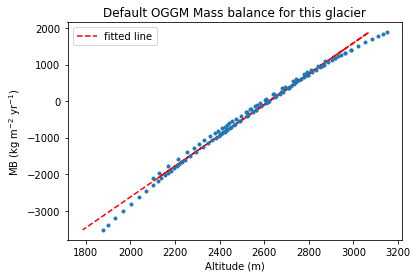

In [9]:
plt.plot(intercept + slope*mb_on_z, mb_on_z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [10]:
mb_on_z[0], z[0]

(1402.5226456339483, 2987.5110218761565)

In [11]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2019-10-02 10:37:40: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 7 glaciers


In [12]:
import xarray as xr
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

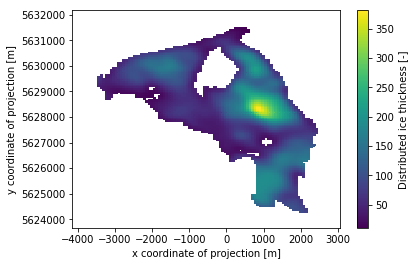

In [13]:
ds_default.distributed_thickness.plot();

In [14]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb

# min to max gradients
grad = [5.8, 9.8, 5.9, 9.8, 7.5, 5.3, 5.8] # mm w.e. m-1 
#data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92] # mm w.e. m-1 

glacier = ['Kokanee', 'Haig', 'Conrad', 'West Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

for i in range(7):
    gdir = gdirs[i]
    workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[i]);


# # Let's apply a linear MB instead
# from oggm.core.climate import apparent_mb_from_linear_mb

# workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[i]);

2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-10-02 10:37:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


{'ela_h': 2582.91795408468, 'grad': 6.84}
{'ela_h': 2670.4536893891946, 'grad': 9.8}
{'ela_h': 2547.6544116847076, 'grad': 7.11}
{'ela_h': 2528.2074934704638, 'grad': 9.8}
{'ela_h': 2497.8304694173885, 'grad': 10.84}
{'ela_h': 2495.3736919704334, 'grad': 6.01}
{'ela_h': 2337.0943128919325, 'grad': 7.92}


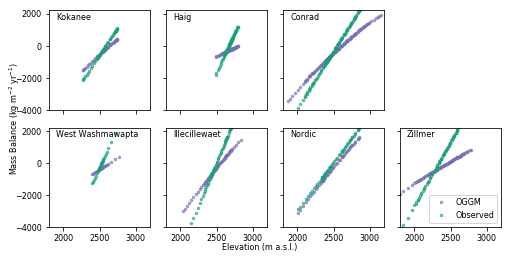

In [95]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

f, axarr = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(7.04, 3.52))
i, j = 0, 0

for val in range(7):
    gdir = gdirs[val]
    params = gdir.read_pickle('linear_mb_params')
    print(params)

    mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance,
                                         check_calib_params=False)
    z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
    mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR
    
    #max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
    l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad']) #, max_mb=2000.) 
    l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR


    gdir = gdirs[i]
    axarr[i, j].plot(z, mb_on_z, '.', color='#7570b3', alpha=0.6, markersize=5, label='OGGM'); #markeredgecolor='k');
    axarr[i, j].plot(z, l_mb_on_z, '.', color='#1b9e77', alpha=0.6, markersize=5, label='Observed');
#     axarr[i, j].set_xticklabels(rotation = 45, ha="right")
    plt.xlim(1800, 3200)
    plt.ylim(-4000, 2200)
    axarr[i, j].text(1900, 1600, glacier[val])
    axarr[0, 3].axis('off')
#     plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
    #     plt.ylabel('Altitude (m)');
#     for tick in axarr[i, j].get_xticklabels():
        #tick.set_rotation(90)
    j += 1

    if val == 2: #changed to 2, 1 worked for 2x2 panel plot
        i += 1
        j = 0
        
plt.legend();   
plt.tight_layout()
# plt.suptitle('MB (kg m$^{-2}$ yr$^{-1}$)', y=0.03, fontsize=12)
plt.suptitle('Elevation (m a.s.l.)', y=0.035, fontsize=8)#ha='center', va ='baseline',
# plt.suptitle('Mass Balance (kg m$^{-2}$ yr$^{-1}$)', x=0.0, y=0.5, rotation='vertical', fontsize=8)
plt.text(-3625, 5650, 'Mass Balance (kg m$^{-2}$ yr$^{-1}$)', rotation='vertical', fontsize=8)

plt.savefig('/home/pelto/Desktop/ice_thick/SMB_gradients_7.png', dpi=300)
plt.show()

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)


slope: 0.126263    intercept: 2337.094313   R-squared: 1.000000


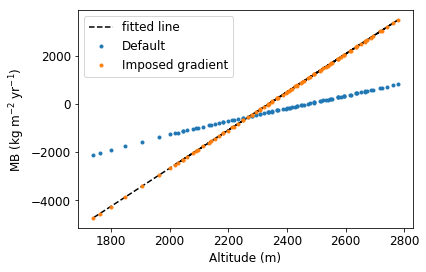

In [17]:
plt.plot(intercept + slope*l_mb_on_z, l_mb_on_z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

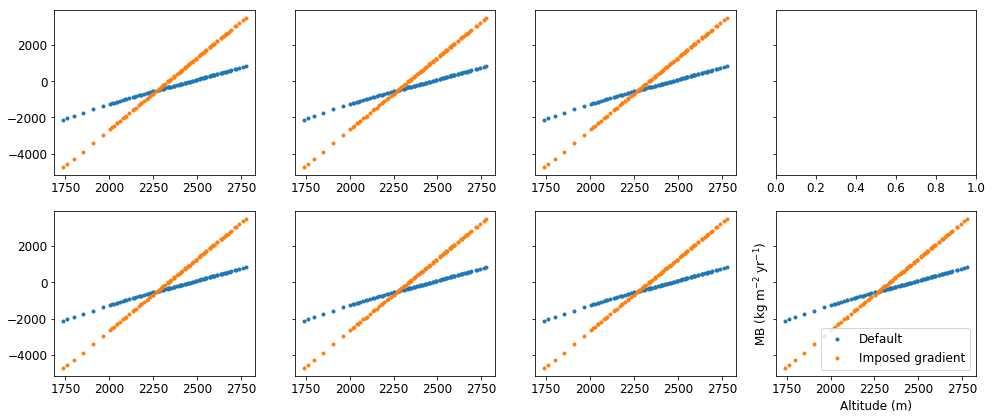

In [18]:

f, axarr = plt.subplots(2, 4, sharey=True, figsize=(14, 6))

i, j = 0, 0

for val in range(7):
    gdir = gdirs[i]
    axarr[i, j].plot(z, mb_on_z, '.', label='Default');
    axarr[i, j].plot(z, l_mb_on_z, '.', label='Imposed gradient');
    plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
    plt.xlabel('Altitude (m)');

    j += 1

    if val == 2: #changed to 2, 1 worked for 2x2 panel plot
        i += 1
        j = 0

plt.legend();   
plt.tight_layout()
plt.savefig('/home/pelto/Desktop/ice_thick/SMB_gradients.png', dpi=600)
plt.show()

In [19]:
# Now let's recompute the inversion based on this new gradient
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)
workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs)
workflow.execute_entity_task(tasks.filter_inversion_output, gdirs) # unfortunately...
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2019-10-02 10:37:44: oggm.workflow: Execute entity task prepare_for_inversion on 7 glaciers
2019-10-02 10:37:44: oggm.workflow: Execute entity task mass_conservation_inversion on 7 glaciers
2019-10-02 10:37:44: oggm.workflow: Execute entity task filter_inversion_output on 7 glaciers
2019-10-02 10:37:44: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 7 glaciers


In [20]:
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

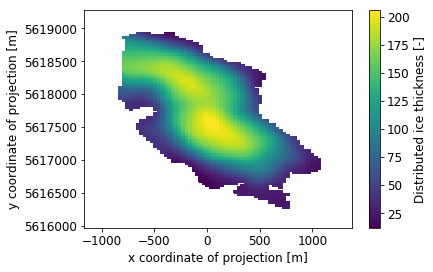

In [21]:
ds_new.distributed_thickness.plot();

In [22]:
(ds_new - ds_default).distributed_thickness.plot(cmap='RdBu');

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

In [ ]:
print(cfg.PARAMS['inversion_glen_a']) ## Glen's creep parameter for the thickness inversion physics
print(cfg.PARAMS['inversion_fs']) ## ## Oerlemans "sliding" factor For the thickness inversion physics
print(cfg.PARAMS['use_shape_factor_for_inversion']) # Allowed is empty, "Adhikari", "Nye" (equivalent to "Adhikari") or "Huss"
print(cfg.PARAMS['default_parabolic_bedshape'])